0.000316	0.17006196
0.000316	0.00422916
0.000316	0.00022029
2025-12-05_20-30-39.png


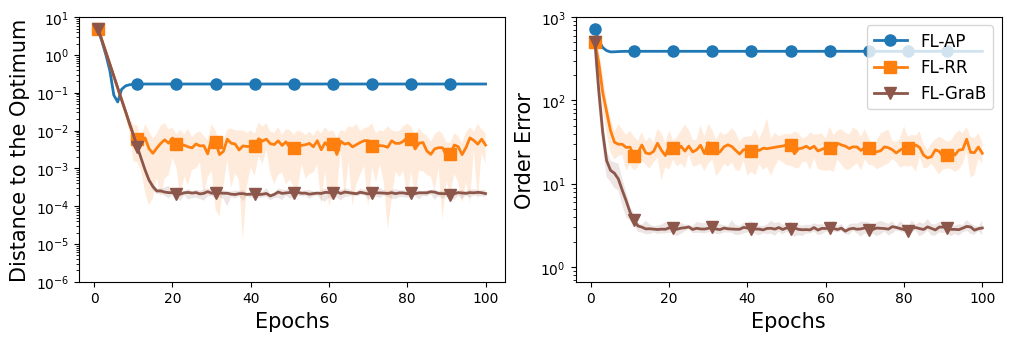

In [ ]:
import sys 
sys.path.append("/home/moon/data/github/ordering/")

import numpy as np
import os
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

from sim.utils.record_utils import read_fromcsv
from plot_utils import COLORS, MARKERS, save_fig_timestamp

def linear_search(pattern, setup, path='save/quad/'):
    lrs = setup['lrs']
    seeds = setup['seeds']

    select = 10

    for i in range(len(lrs)):
        pattern_lr = re.sub(r'sgd\d+\.\d*', 'sgd{}'.format(lrs[i]), pattern)
        distance_seeds = []
        for j in range(len(seeds)):
            file = re.sub(r'seed\d+', 'seed{}'.format(seeds[j]), pattern_lr)
            #print(file)
            file = f'{file}.csv' if '.csv' not in file else file
            if os.path.exists(os.path.join(path, file)):
                df = read_fromcsv(file, path)
            else:
                print("Not found {}".format(os.path.join(path, file)))
                continue
            distance = df.iloc[:, 1].values # get the param error or the distance
            distance_seeds.append(distance.tolist()) # numpy to list
        distance_seeds = np.vstack(distance_seeds) # list to numpy

        if i == 0:
            avg_distance_seeds = distance_seeds.mean(axis=0)
            avg_distance_seeds_rounds = avg_distance_seeds[-select:].mean(axis=0)
            best_avg_distance = avg_distance_seeds_rounds
            best_lr = lrs[i]
        else:
            # https://stackoverflow.com/a/67629235/16304578
            if np.isnan(distance_seeds.astype(float)).any():
                #print("Skipping due to nan or inf")
                continue
            avg_distance_seeds = distance_seeds.mean(axis=0)
            avg_distance_seeds_rounds = avg_distance_seeds[-select:].mean(axis=0)
            if avg_distance_seeds_rounds <= best_avg_distance:
                # prefer the large learning rate: '<=' vs '<'
                best_avg_distance = avg_distance_seeds_rounds
                best_lr = lrs[i]
    
    print('{}\t{:.8f}'.format(best_lr, best_avg_distance))
    return best_lr

def plot_mean(ax, patterns, seeds, setup, path='save/quadratic/'):
    labels = ["cSGD", "IG", "SO", "RR", "GraB-proto", "PairGraB-proto", "GraB", "PairGraB"]
    ylabels = ['Epoch', 'Distance to the Optimum', 'Order Error']
    col = setup['col']
    start = setup['start']
    end = setup['end']
    lines = []
    for i in range(len(patterns)):
        error_seeds = []
        for seed in seeds:
            file = re.sub(r'seed\d+', 'seed{}'.format(seed), patterns[i])
            file = f'{file}.csv' if '.csv' not in file else file
            if os.path.exists(os.path.join(path, file)):
                df = read_fromcsv(file, path)
            else:
                print("Not found {}".format(os.path.join(path, file)))
            error = df.iloc[:, col].values # get the param error and order error
            error_seeds.append(error.tolist())
        error_seeds = np.vstack(error_seeds)

        x = range(start, end+1)
        # if "GraB" in patterns[i]:
        #     linestyle = '-'
        # else:
        linestyle = '-'
        if "PairGraB_" in patterns[i]:
            color = COLORS[5]
            marker = MARKERS[5]
        else:
            color = COLORS[i]
            marker = MARKERS[i]
        #color=COLORS[i]
        line, = ax.plot(x, error_seeds.mean(axis=0), linestyle=linestyle, color=color, lw=2, label=labels[i], marker=marker, markersize=8, markevery=10)
        #plt.fill_between(x_axis, FedAvgdata[i].mean(axis=0) - FedAvgdata[i].std(axis=0), FedAvgdata[i].mean(axis=0) +FedAvgdata[i].std(axis=0), facecolor=colors[i], alpha=0.25) 
        fill = ax.fill_between(x, error_seeds.min(axis=0), error_seeds.max(axis=0), facecolor=color, alpha=0.15)
        lines.append(line)
    ax.set_yscale('log')
    ax.set_ylabel(ylabels[col], fontsize=15)
    ax.set_xlabel("Epochs", fontsize=15)
    return lines



def main():
    #global path, lrs, seeds, args
    path = f"/home/moon/data/github/ordering/save/quad/"
    seeds = [0,1,2,3,4,5,6,7,8,9]
    #seeds = [0,1]
    #lrs = [0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0]
    #lrs = [0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0]
    lrs = [0.000316, 0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0]
    lrs = lrs[2:3]

    pattern_algs_sgd = [
       #"cSGD",
       "IG",
       #"SO",
       "RR",
       "RR-FF",
       "GraB-proto",
       #"PairGraB-proto",
       "GraB",
       "PairGraB",
    ]

    pattern_algs_fl = [
       #"cSGD",
       "IG",
       #"SO",
       "RR",
       #"RR-FF",
       #"GraB-proto",
       #"PairGraB-proto",
       #"GraB",
       "PairGraB",
    ]
    pattern_algs = pattern_algs_fl
    #pattern_ends = "sgd_quad0_{}_M1000_K1_R100,1_sgd1.0,0.0,0.0001_exp1.0_seed0.csv"
    #pattern_ends = "sgd_quadh0_{}_M1000_K1_R100,1_sgd1.0,0.0,0.0001_exp1.0_seed0.csv"
    #pattern_ends = "sgd_quadh1_{}_M1000_K1_R100,1_sgd1.0,0.0,0.0001_exp1.0_seed0.csv"
    
    #pattern_ends = "fl_quad0_{}_M1000,2_K5_R100,1_sgd1.0,0.0,0.0001_exp1.0_seed0.csv"
    #pattern_ends = "fl_quadh0_{}_M1000,2_K5_R100,1_sgd1.0,0.0,0.0001_exp1.0_seed0.csv"
    pattern_ends = "fl_quadh1_{}_M1000,2_K5_R100,1_sgd1.0,0.0,0.0001_exp1.0_seed0.csv"
    patterns = [pattern_ends.format(alg) for alg in pattern_algs]

    lr_patterns = []
    for pattern in patterns:
        best_lr = linear_search(pattern, setup={"lrs": lrs, "seeds": seeds}, path=path)
        lr_pattern = re.sub(r'sgd\d+\.\d*', 'sgd{}'.format(best_lr), pattern)
        lr_patterns.append(lr_pattern)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3.3), constrained_layout=True)
    for i in range(2):
        lines = plot_mean(axes[i], patterns = lr_patterns, seeds=seeds, setup={'start': 1, 'end': 100, 'col': [1,2][i], 'step': 1, 'compute': 0, 'select': 10}, path=path)
    
    labels = pattern_algs
    #fig.legend(handles=lines, labels=labels, loc='center right', ncols=1, fontsize=14, bbox_to_anchor=(1.24, 0.68))#bbox_to_anchor=(0.5, -0.05), 
    #labels = ["FL-RR (RR)", "FL-GraB (PairGraB)"]
    #labels = ["cSGD", "SO", "RR", "FlipFlop", "GraB-proto", "GraB", "PairGraB"]
    #labels = ["AP", "RR", "FlipFlop", "GraB-proto", "GraB", "PairGraB"]
    labels = ["FL-AP", "FL-RR", "FL-GraB"]
    #labels = pattern_algs
    axes[1].legend(handles=lines, labels=labels, fontsize=12, loc='upper right', ncols=1)
    axes[0].set_ylim(ymax=10, ymin=0.000001)
    axes[1].set_ylim(ymax=1000, ymin=0.67)
    save_fig_timestamp(fig, format='.png', path="./")
    #save_fig_timestamp(fig)



if __name__ == '__main__':
    main()
